In [1]:
import scvelo as scv
import scanpy as sc
import pickle as pickle
from eval_utils import cross_boundary_correctness, inner_cluster_coh
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt

In [2]:
datasets = ['IntestinalOrganoids', 'Pancreas_without_cc',  'scNT_seq',
           'Pancreas_with_cc', 'DentateGyrus' , 'MouseBoneMarrow', 'MouseErythroid', 'Hindbrain_pons', 'HumanBoneMarrow',
           'RetinaDevelopment']
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'

IntestinalOrganoids
Filtered out 3076 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/64 cores)


  0%|          | 0/460 [00:00<?, ?gene/s]

    finished (0:00:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/3831 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
({('Stem cells', 'TA cells'): -0.025664027023406942, ('Stem cells', 'Goblet cells'): 0.18554545000625738}, 0.07994071149142522)
Pancreas_without_cc
Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/64 cores)


  0%|          | 0/1083 [00:00<?, ?gene/s]

KeyboardInterrupt: 

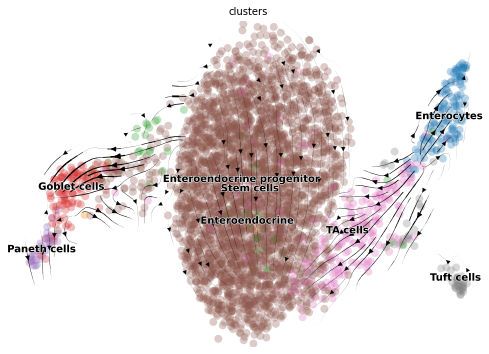

In [3]:
for dataset in datasets:
    print(dataset)
    # Load and setup data:
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.recover_dynamics(adata, n_jobs = 8)
    scv.tl.velocity(adata, vkey='velocity', mode='dynamical')
    scv.pp.neighbors(adata)
    scv.tl.velocity_graph(adata, vkey='velocity')
    scv.tl.velocity_embedding(adata, vkey='velocity')
    fix, ax = plt.subplots(1, 1, figsize = (8, 6))
    scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                     show = False, ax = ax)
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_scvelo1.png')
    # Calculate performance:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    scv.pp.neighbors(adata)
    mean_score = cross_boundary_correctness(adata = adata, k_cluster = 'clusters',
                               k_velocity = 'velocity', cluster_edges = ground_truth)
    print(mean_score)
    tab = pd.read_csv(save_dir + dataset + '_scores.csv', index_col = 0)
    tab.loc['scvelo1',:] = np.array(list(mean_score[0].values()) + [mean_score[1]])
    tab.to_csv(save_dir + dataset + '_scores.csv')   

In [ ]:
adata

In [ ]:
dataset = 'IntestinalOrganoids'

In [ ]:
adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')

In [ ]:
adata.obs['clusters'].value_counts()